# Energy Maneuverability Diagrams

Code to enable the easy generation of an EM diagram. 

Example of a Matlab based EM diagram generator.

![Matlab EM Diagram Generator](images/F-15C%20Matlab%20EM%20Diagram.png)

Example of an EM diagram for an F-16.

![F-16 EM Example](images/F16%20EM%20Example.jpg)

General EM diagram traits.

![General EM Diagram](images/General%20EM.JPG)


### Basic Turn Performance

Assuming a level turn.

$ \large lateral \: accel = g \sqrt{n_z^2 - 1}$

$ \large a = \frac{V^2}{R}$

$ \large R = \frac{V^2} {g \sqrt{n_z^2 -1 }}$

$ \large \omega = \frac{g \sqrt{n_z^2 -1}} {V}$  rad/s

### Corner Speed

$ \large V = \sqrt{ \frac{2 n_{zmax} W} {\rho C_{Lmax} S} } $ TAS

### Specific Excess Energy

$ \large P_S = V(\frac{T - D}{W}) $

$ P_S = Specific \: Excess \: Energy $

$ V = Speed $

$ T = Thrust $

$ D = Drag $

$ W = Weight $

### Calculating Lines of Constant $P_s$

For a given Ps, e.g. 200ft/s run through the speed range and for each speed use the thrust model to calculate thrust based on altitude and Mach. Then solve for drag.

$ \large D = T - P_s \frac{W}{V} $

Once the drag has been solved for we then need to solve for $C_l$.

$ \large C_D = C_{D0} + C_{D_i} $

$ \large C_{D_i} = \frac{C_L^2}{\pi e AR} $

$ \large k = \frac{1}{\pi e AR} $

$ \large C_{D_i} = k  C_L^2 $

TODO - need to take drag increase due to Mach into account. Note the distinct kink in the $P_S$ curves around Mach 0.9 for the F-16 EM diagram example.

![Drag Divergence Mach Number](images/Drag%20Divergence%20Mach%20Number.png)

Given the calculated $C_l$, weight, altitude and speed a load factor can be calculated, which is then used to calculate a turn rate $\omega$. Providing a $(speed, \omega)$ point for the specified line of constant $P_s$  on the graph.



### Thrust Model

From JSBSim for the F100-PW-229 engine model file.

`
<turbine_engine name="F100">
  <milthrust>   17800.0 </milthrust>
  <maxthrust>   29000.0 </maxthrust>
`

`
  <function name="AugThrust">
   <table>
    <independentVar lookup="row">velocities/mach</independentVar>
    <independentVar lookup="column">atmosphere/density-altitude</independentVar>
    <tableData>
           -10000       0   10000   20000   30000   40000   50000   60000
     0.0    1.1816  1.0000  0.8184  0.6627  0.5280  0.3756  0.2327  0.0
     0.2    1.1308  0.9599  0.7890  0.6406  0.5116  0.3645  0.2258  0.0
     0.4    1.1150  0.9474  0.7798  0.6340  0.5070  0.3615  0.2240  0.0
     0.6    1.1284  0.9589  0.7894  0.6420  0.5134  0.3661  0.2268  0.0
     0.8    1.1707  0.9942  0.8177  0.6647  0.5309  0.3784  0.2345  0.0
     1.0    1.2411  1.0529  0.8648  0.7017  0.5596  0.3983  0.2467  0.0
     1.2    1.3287  1.1254  0.9221  0.7462  0.5936  0.4219  0.2614  0.0
     1.4    1.4365  1.2149  0.9933  0.8021  0.6360  0.4509  0.2794  0.0
     1.6    1.5711  1.3260  1.0809  0.8700  0.6874  0.4860  0.3011  0.0
     1.8    1.7301  1.4579  1.1857  0.9512  0.7495  0.5289  0.3277  0.0
     2.0    1.8314  1.5700  1.3086  1.0474  0.8216  0.5786  0.3585  0.0
     2.2    1.9700  1.6900  1.4100  1.2400  0.9100  0.6359  0.3940  0.0
     2.4    2.0700  1.8000  1.5300  1.3400  1.0000  0.7200  0.4600  0.0
     2.6    2.2000  1.9200  1.6400  1.4400  1.1000  0.8000  0.5200  0.0
    </tableData>
   </table>
  </function>
`

### Code

In [1]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from Atmosphere import ISAtmosphere
from Conversions import *

In [2]:
class F15:
    def __init__(self):
        self.CLMax = 1.213096
        self.S = 608
        self.Maxg = 9
        self.Vne = 800
        self.DragIndex = 12.1
        self.k = 0.133  # 1/(pi * e * AR)

    def CD0(self, mach):
        # TODO Add mach effect
        return 0.023 + self.DragIndex / 1e4

    def Thrust(self, altitude, mach):
        # TODO Use thrust (altitude, mach) factor table
        #return 46000
        return 30000

In [3]:
class IF35A:
    def __init__(self):
        self.CLMax = 1.8
        self.S = 460
        self.Maxg = 9
        self.Vne = 900
        self.DragIndex = 0
        self.k = 1/(math.pi * 0.8 * 2.681265)  # 1/(pi * e * AR)

    def CD0(self, mach):
        # TODO Add mach effect
        return 0.016 + self.DragIndex / 1e4

    def Thrust(self, altitude, mach):
        # TODO Use thrust (altitude, mach) factor table
        return 22000

In [4]:
# Default axes limits
maxCAS = 1200
maxTurnRate = 25

use_impact_pressure = False

g = 32.17405

font = {'family': 'Times New Roman',
        'color':  'darkred',
        'weight': 'normal',
        'size': 10,
        }

In [5]:
# Lateral g given a load factor and assuming level turn
def lateral_g(load_factor):
    return math.sqrt(load_factor**2 - 1)

In [6]:
def speed_and_turnrate(nlf, radius):
    lateralg = lateral_g(nlf)
    speed = math.sqrt(lateralg*g*radius)
    turnrate = 360 / ((2 * math.pi * radius) / speed)
    return (speed, turnrate)

In [7]:
def plot_turn_radius_lines(ax, radii, gs, altitude):
    for radius in radii:
        speeds = []
        turnrates = []
        for nlf in gs:
            (speed, turnrate) = speed_and_turnrate(nlf, radius)
            speeds.append(fpsTokt(TAStoCAS(speed, altitude)))
            turnrates.append(turnrate)
        ax.plot(speeds, turnrates, color='black', linestyle='--')
        ax.text(speeds[-1], turnrates[-1], '  {0} ft'.format(radius), fontdict=font, horizontalalignment='left', verticalalignment='bottom')

In [8]:
def plot_g_lines(ax, gs, radii, altitude):
    for nlf in gs:
        speeds = []
        turnrates = []
        for radius in radii:
            (speed, turnrate) = speed_and_turnrate(nlf, radius)
            speeds.append(fpsTokt(TAStoCAS(speed, altitude)))
            turnrates.append(turnrate)
        ax.plot(speeds, turnrates, color='black')
        ax.text(speeds[0], turnrates[0], 'n={0}  '.format(nlf), fontdict=font, horizontalalignment='right', verticalalignment='center')

In [9]:
def render_background(ax, altitude, g_values, radius_values):
    ax.set_xlim(xmin=0, xmax=maxCAS)
    ax.set_ylim(ymin=0, ymax=maxTurnRate)

    plot_turn_radius_lines(ax, radius_values, g_values, altitude)
    plot_g_lines(ax, g_values, range(min(radius_values), max(radius_values) + 100, 100), altitude)

    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.arange(xmin, xmax, 100))

    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='0.85', linestyle='--')
    ax.grid(b=True, which='major', color='0.65', linestyle='-')

    ax.set_ylabel('Turn Rate (deg/s)')
    ax.set_xlabel('Calibrated Airspeed (kt)')

    # Add Mach x-axis, CAS to Mach isn't linear
    (CASMin, CASMax) = ax.get_xlim()
    MachMin = CAStoMach(ktTofps(CASMin), altitude)
    MachMax = CAStoMach(ktTofps(CASMax), altitude)

    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 46))
    ax2.set_xlabel('Mach Number')

    ax2.set_xlim(CASMin, CASMax)
    mach_ticks = []
    mach_labels = []
    for mach in np.arange(MachMin, MachMax, 0.2):
        cas = fpsTokt(MachtoCAS(mach, altitude))
        m = CAStoMach(ktTofps(cas), altitude)
        mach_ticks.append(cas)
        mach_labels.append('{0:.1f}'.format(mach))
    ax2.xaxis.set_ticks(mach_ticks)
    ax2.xaxis.set_ticklabels(mach_labels)

In [10]:
def render_manuever_envelope(ax, aircraft, altitude, weight):
    # Calculate corner speed
    if use_impact_pressure:
        corner_mach = MachFromImpactPressure((aircraft.Maxg * weight)/(aircraft.CLMax * aircraft.S), ISAtmosphere.Pressure(altitude))
        corner_speed_cas = MachtoCAS(corner_mach, altitude)
        corner_speed_cas_kt = fpsTokt(corner_speed_cas)
    else:
        corner_speed_tas = math.sqrt((2 * aircraft.Maxg * weight) / (ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S))
        corner_speed_cas = TAStoCAS(corner_speed_tas, altitude)
        corner_speed_cas_kt = fpsTokt(corner_speed_cas)

    # 
    intervals = int((aircraft.Vne - corner_speed_cas_kt) / 10 + 1)
    airspeeds = np.linspace(corner_speed_cas_kt, aircraft.Vne, intervals)

    turn_rates = []
    for airspeed in airspeeds:
        turn_rate = g*math.sqrt(aircraft.Maxg**2 - 1)/CAStoTAS(ktTofps(airspeed), altitude)
        turn_rates.append(math.degrees(turn_rate))

    # Drop down to x-axis at VNE
    airspeeds = np.append(airspeeds, aircraft.Vne)
    turn_rates.append(0)

    ax.plot(airspeeds, turn_rates, color='red', linewidth=3.0)

    # Accelerated stall side
    one_g_stall_speed_tas = math.sqrt( (2 * weight) / (ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S) )
    one_g_stall_speed_cas = TAStoCAS(one_g_stall_speed_tas, altitude)
    one_g_stall_speed_cas_kt = fpsTokt(one_g_stall_speed_cas)

    #
    intervals = int((corner_speed_cas_kt - one_g_stall_speed_cas_kt) / 10 + 1)
    airspeeds = np.linspace(one_g_stall_speed_cas_kt + 1, corner_speed_cas_kt, intervals)

    turn_rates = []
    for airspeed in airspeeds:
        tas = CAStoTAS(ktTofps(airspeed), altitude)
        if use_impact_pressure:
            mach = CAStoMach(ktTofps(airspeed), altitude)
            nlf = (ImpactPressure(mach, altitude) * aircraft.CLMax * aircraft.S) / weight
        else:
            nlf = (0.5 * ISAtmosphere.Density(altitude) * aircraft.CLMax * aircraft.S * tas * tas) / weight
        turn_rate = g*math.sqrt(nlf**2 - 1)/tas
        turn_rates.append(math.degrees(turn_rate))

    ax.plot(airspeeds, turn_rates, color='red', linewidth=3.0)

In [11]:
def render_ps_line(ax, aircraft, altitude, weight, ps):
    
    # TODO Still need to include mach drag increase
    
    colorVal = 'green' if ps >= 0 else 'blue'

    # Airspeed range and interval
    VneTAS = CAStoTAS(ktTofps(aircraft.Vne), altitude)
    MinTAS = CAStoTAS(ktTofps(100), altitude)
    intervals = int((VneTAS -  MinTAS) / 10 + 1)
    airspeeds = np.linspace(MinTAS, VneTAS, intervals)

    CAS_speeds = []
    turn_rates = []

    for tas in airspeeds:
        mach = ISAtmosphere.Mach(tas, altitude)
        Drag = aircraft.Thrust(altitude, mach) - ps * (weight / tas)
        if use_impact_pressure:
            q = ImpactPressure(mach, altitude)
        else:
            q = 0.5 * ISAtmosphere.Density(altitude) * tas**2
        InducedDrag = Drag - q * aircraft.CD0(mach) * aircraft.S
        if InducedDrag > 0:
            Cl = math.sqrt(InducedDrag / (aircraft.k * q * aircraft.S))
            Lift = q * Cl * aircraft.S
            nLF = Lift / weight
            if nLF > aircraft.Maxg:
                ax.plot(CAS_speeds, turn_rates, color=colorVal, linewidth=2.0)
                CAS_speeds.clear()
                turn_rates.clear()
            elif nLF > 1.0 and Cl <= aircraft.CLMax:
                turn_rate = g*math.sqrt(nLF**2 - 1)/tas
                turn_rates.append(math.degrees(turn_rate))
                CAS_speeds.append(fpsTokt(TAStoCAS(tas, altitude)))

    ax.plot(CAS_speeds, turn_rates, color=colorVal, linewidth=2.0)

    return


def render_ps_lines(ax, aircraft, altitude, weight, ps_values):
    for ps in ps_values:
        render_ps_line(ax, aircraft, altitude, weight, ps)

In [12]:
def render(aircraft, altitude, weight, g_values, radius_values, ps_values, legend):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    render_background(ax, altitude, g_values, radius_values)

    render_manuever_envelope(ax, aircraft, altitude, weight)

    render_ps_lines(ax, aircraft, altitude, weight, ps_values)

    # HACK for now, render_manuever_envelope resets xlim to (75, 825)
    # TODO Should be able to determine these from the max data points, rounded up etc.
    ax.set_xlim(0, maxCAS)
    ax.set_ylim(0, maxTurnRate)

    # TODO Can generate most of entries automatically
    patches = []
    for line in legend:
        patches.append(mpatches.Patch(color='white', label=line))
    plt.legend(handles=patches)

    plt.show()

<IPython.core.display.Javascript object>


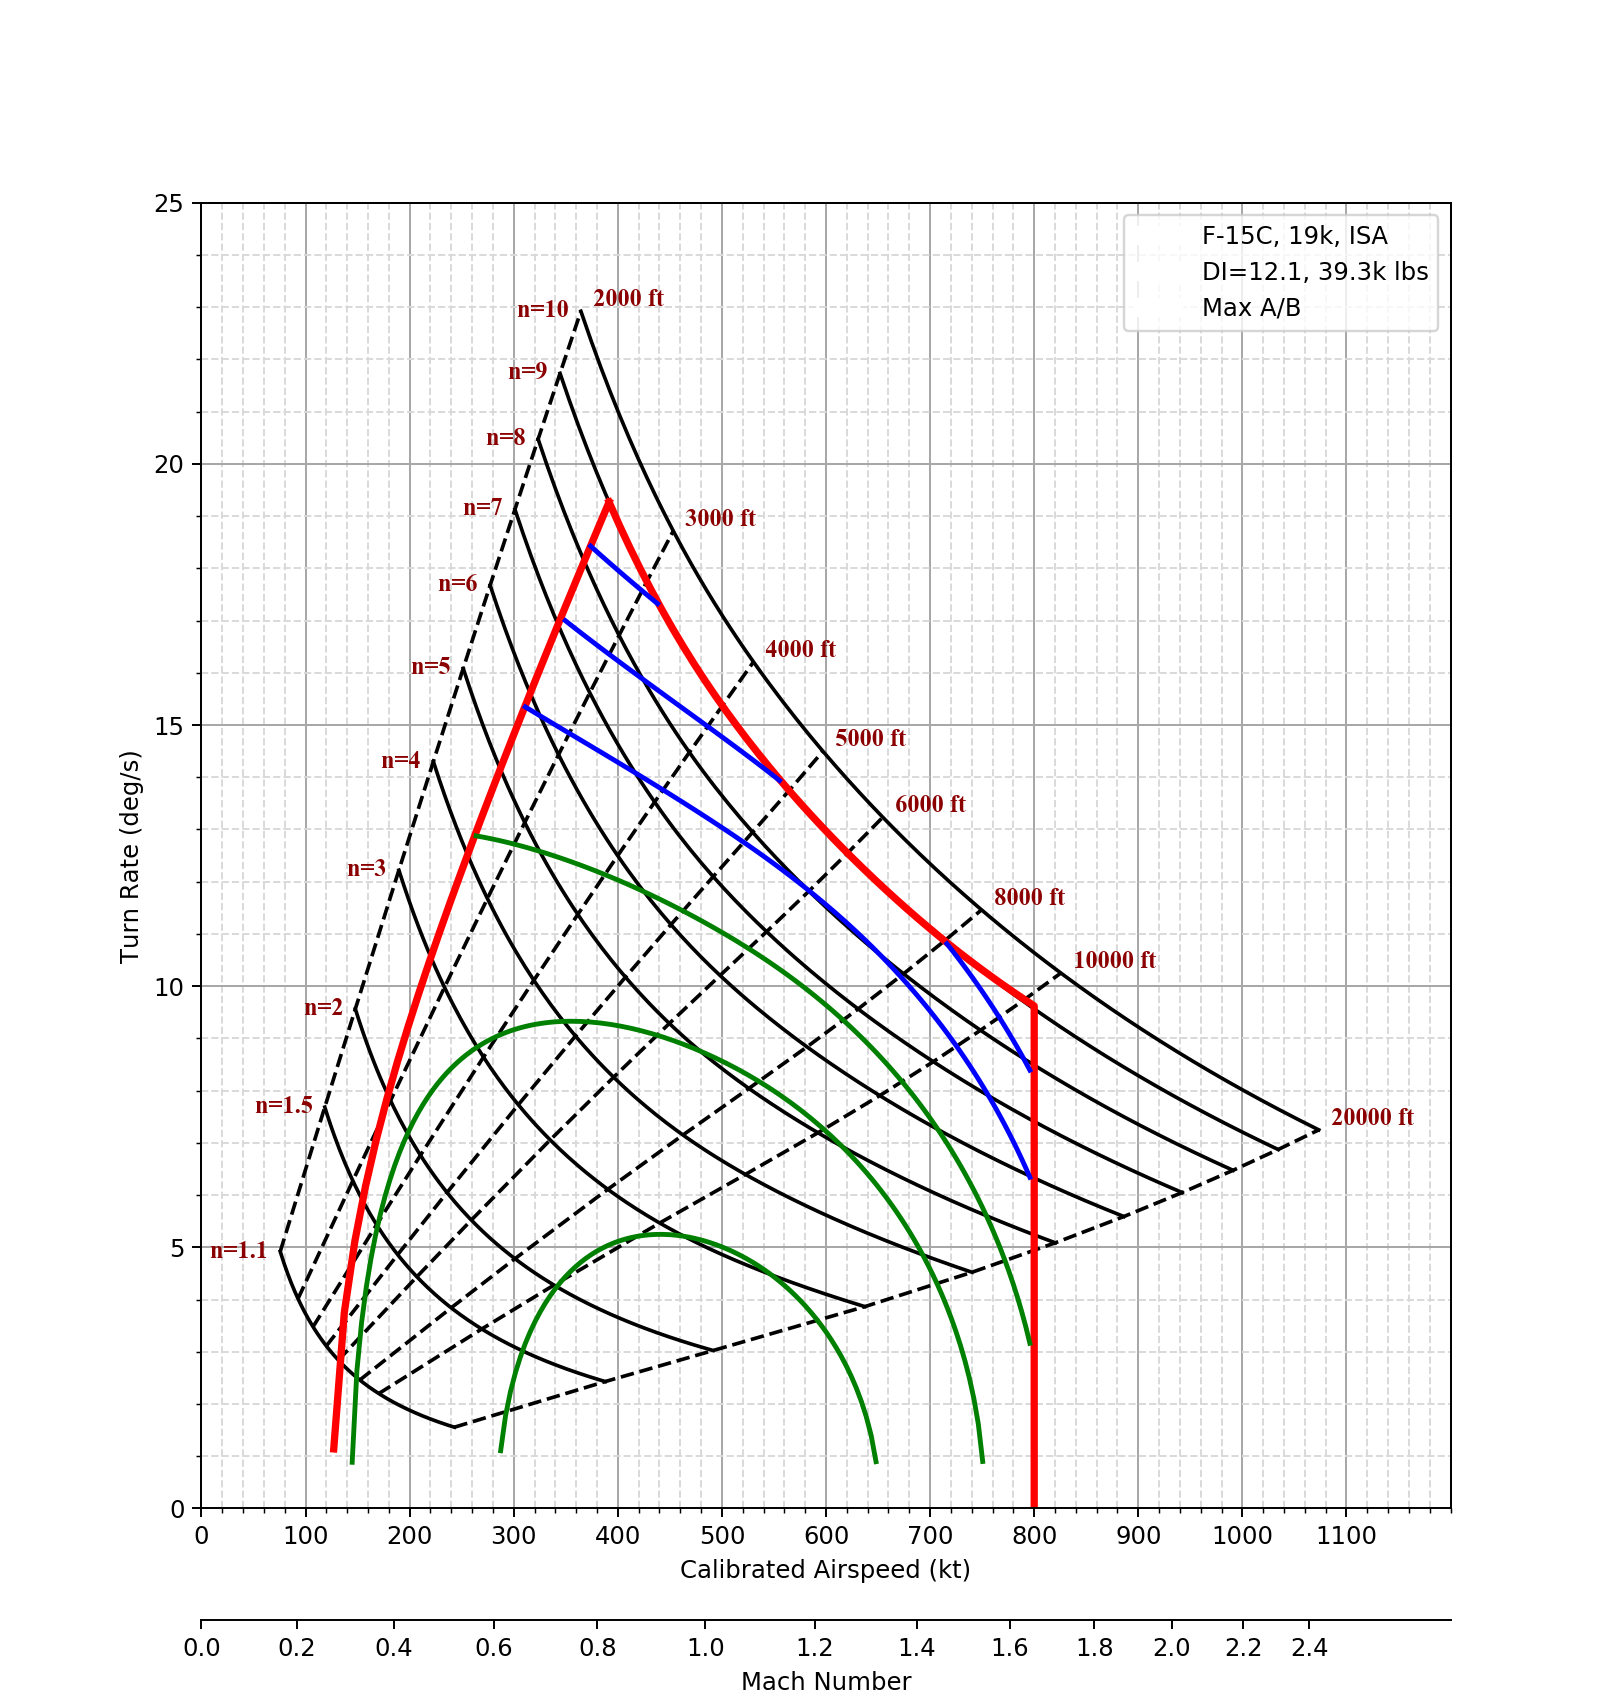

In [13]:
aircraft = F15()
altitude = 19000
weight = 39300

legend = ['F-15C, 19k, ISA', 'DI=12.1, 39.3k lbs', 'Max A/B']

g_values = [1.1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
radius_values = [2000, 3000, 4000, 5000, 6000, 8000, 10000, 20000]
ps_values = [ 0, 200, 400, 600, -200, -400, -600 ]

render(aircraft, altitude, weight, g_values, radius_values, ps_values, legend)

<IPython.core.display.Javascript object>


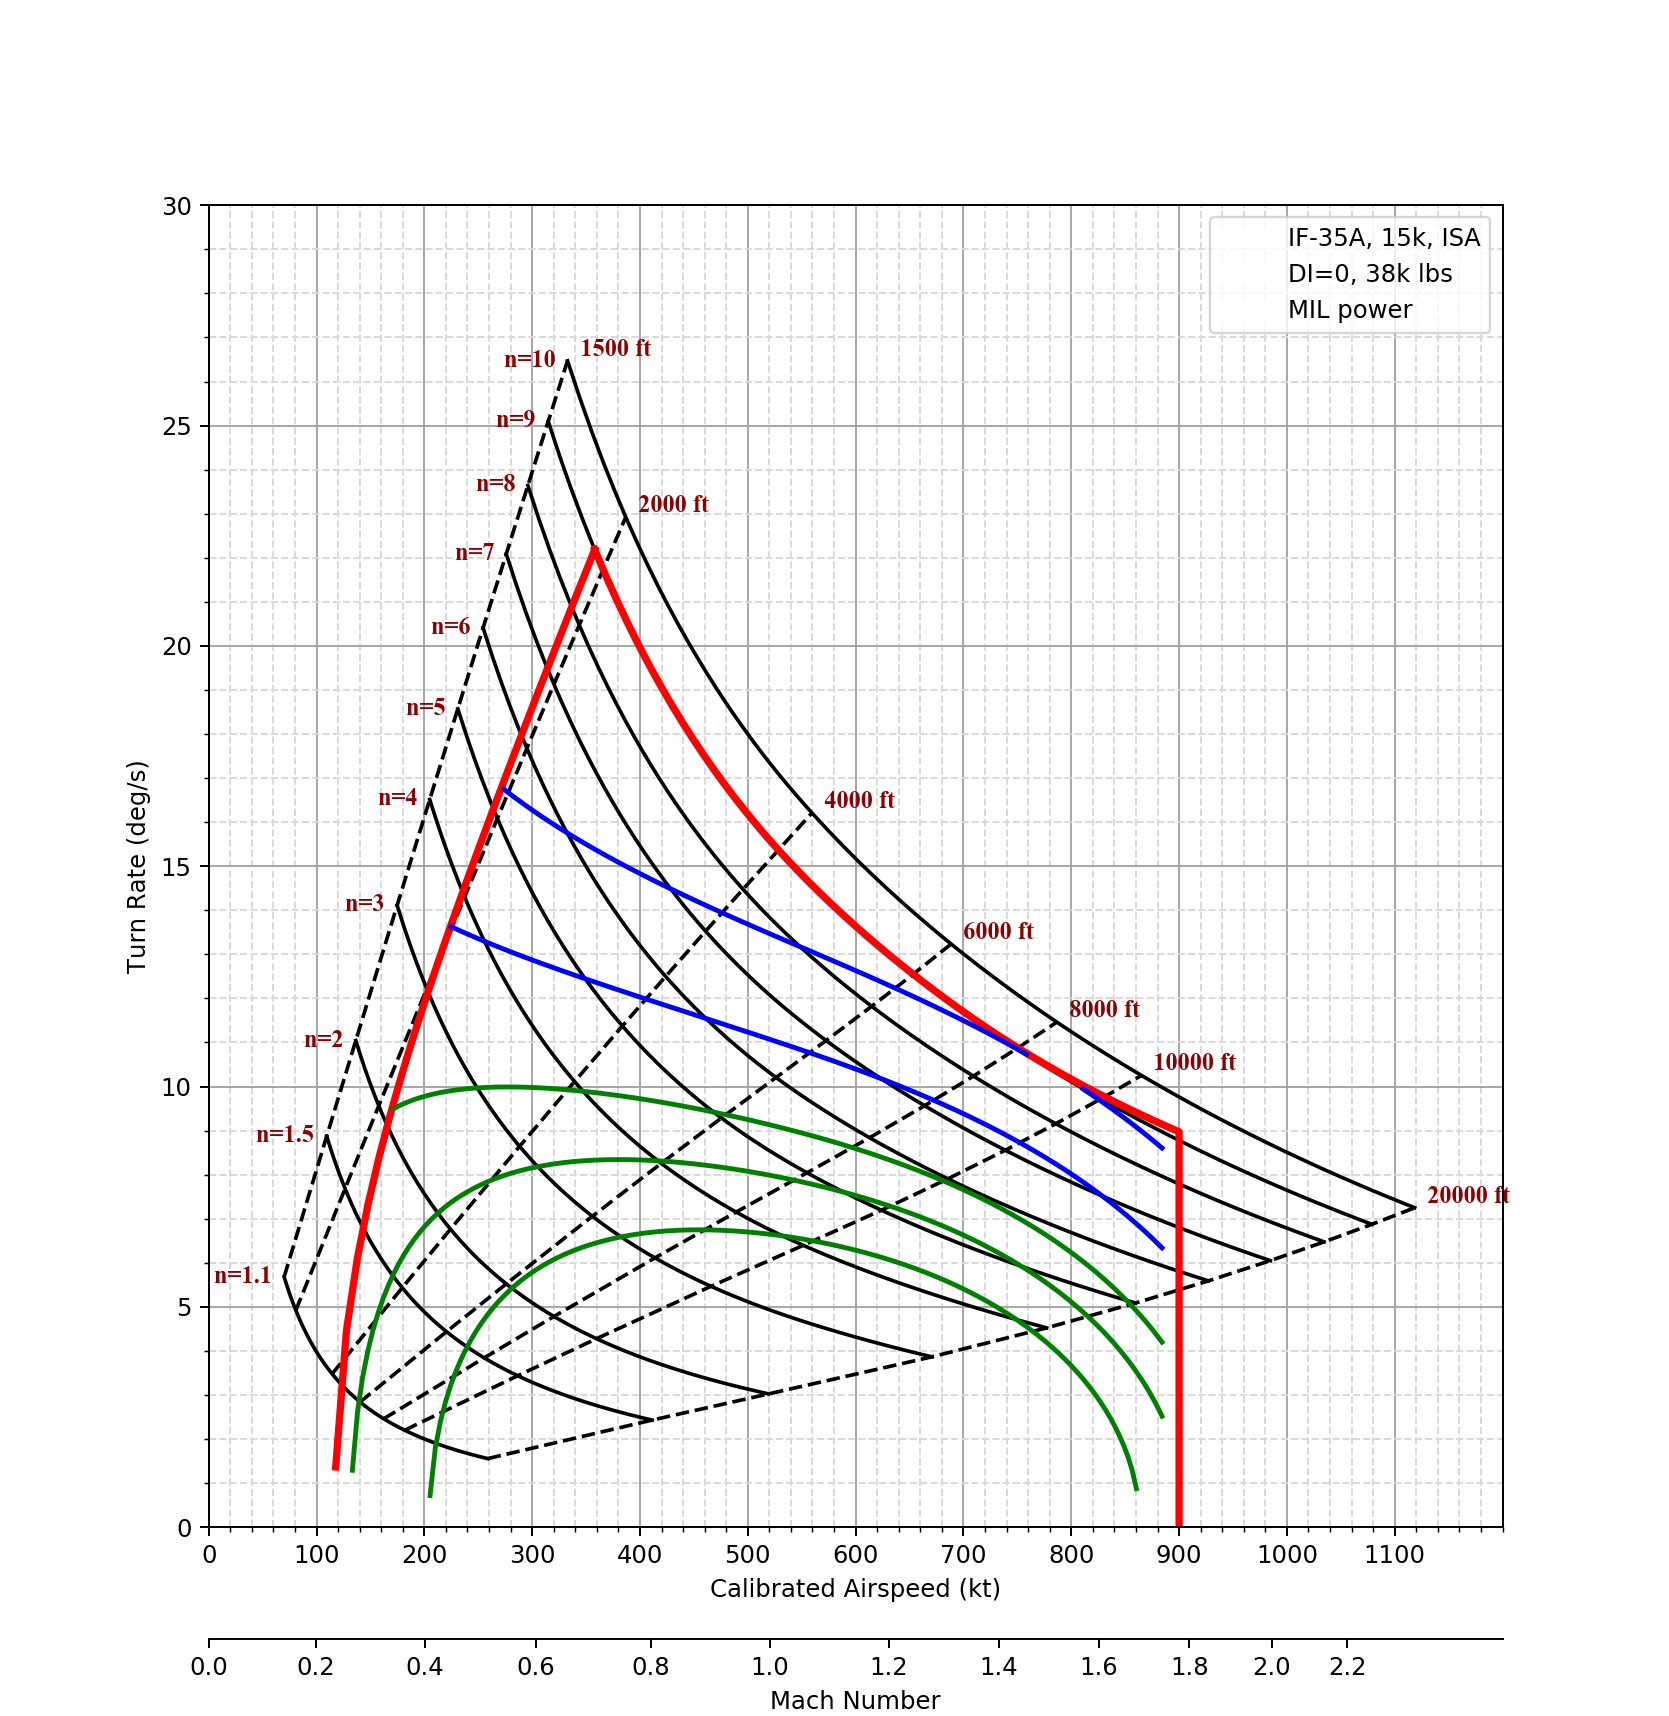

In [14]:
aircraft = IF35A()
altitude = 15000
weight = 38000

legend = ['IF-35A, 15k, ISA', 'DI=0, 38k lbs', 'MIL power']

radius_values = [1500, 2000, 4000, 6000, 8000, 10000, 20000]
ps_values = [ 0, 100, 200, -200, -500 ]

maxTurnRate = 30

render(aircraft, altitude, weight, g_values, radius_values, ps_values, legend)